In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load data 
data = pd.read_csv('tau.csv').drop('Unnamed: 0', axis=1)
data = data.to_numpy()
data

array([[1.16916445, 1.02185722, 1.01244055, ..., 1.19327991, 1.21754489,
        1.22949659],
       [1.16995929, 1.02214948, 1.01310729, ..., 1.19415383, 1.21797399,
        1.22971787],
       [1.17092435, 1.02250575, 1.01390682, ..., 1.1952389 , 1.21850528,
        1.22997825],
       ...,
       [2.43949264, 1.32819257, 2.45367896, ..., 1.6649272 , 1.24544167,
        1.12727977],
       [2.44285586, 1.32862446, 2.45690372, ..., 1.66493728, 1.24532788,
        1.12708391],
       [2.44612196, 1.32902318, 2.45985474, ..., 1.6649135 , 1.24536996,
        1.12693866]])

In [3]:
def split_data(data, time_steps):
    X, y = [], []
    # normalize data 
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, :])
    return np.array(X), np.array(y)

time_steps = 3  
X, y = split_data(data, time_steps)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (97, 3, 86)
Shape of y: (97, 86)


In [4]:
class SimpleLSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim

        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        out = self.fc(out[:, -1, :])
        return out

In [37]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [115]:
training_loss = []
val_loss = []

X_tensor = torch.tensor(X_train, dtype=torch.float)
y_tensor = torch.tensor(y_train, dtype=torch.float)

X_val = torch.tensor(X_test, dtype=torch.float)
y_val = torch.tensor(y_test, dtype=torch.float)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = SimpleLSTM(input_dim=86, hidden_dim=128, layer_dim=1, output_dim=86)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
min_val_loss = 1000
min_val_epoch = 0

for epoch in range(num_epochs):
    model.train()  
    epoch_training_loss = 0.0
    epoch_val_loss = 0.0

    # training 
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item() * inputs.size(0) 

    epoch_training_loss /= len(dataloader.dataset)
    training_loss.append(epoch_training_loss)

    # validation
    model.eval() 
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0) 


    # Calculate average validation loss for the epoch
    epoch_val_loss /= len(val_dataloader.dataset)
    val_loss.append(epoch_val_loss)
    if epoch_val_loss < min_val_loss:
        min_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        min_val_epoch = epoch

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_training_loss:.8f}, Validation Loss: {epoch_val_loss:.8f}')

print('Training complete.')
print(f'Minimum validation loss: {min_val_loss:.8f} at epoch {min_val_epoch}')


Epoch [10/1000], Training Loss: 0.00163917, Validation Loss: 0.00125365
Epoch [20/1000], Training Loss: 0.00041521, Validation Loss: 0.00039143
Epoch [30/1000], Training Loss: 0.00034411, Validation Loss: 0.00031774
Epoch [40/1000], Training Loss: 0.00027289, Validation Loss: 0.00025729
Epoch [50/1000], Training Loss: 0.00021298, Validation Loss: 0.00020277
Epoch [60/1000], Training Loss: 0.00017780, Validation Loss: 0.00017390
Epoch [70/1000], Training Loss: 0.00015785, Validation Loss: 0.00015567
Epoch [80/1000], Training Loss: 0.00014396, Validation Loss: 0.00013930
Epoch [90/1000], Training Loss: 0.00011872, Validation Loss: 0.00012117
Epoch [100/1000], Training Loss: 0.00010527, Validation Loss: 0.00012093
Epoch [110/1000], Training Loss: 0.00008926, Validation Loss: 0.00009222
Epoch [120/1000], Training Loss: 0.00007518, Validation Loss: 0.00008179
Epoch [130/1000], Training Loss: 0.00006279, Validation Loss: 0.00007746
Epoch [140/1000], Training Loss: 0.00005363, Validation Loss

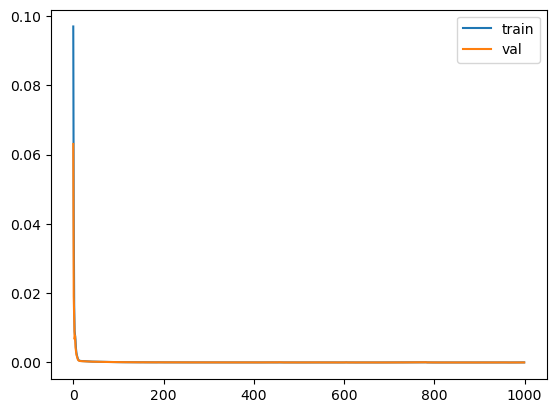

In [116]:
# plot train and val
import matplotlib.pyplot as plt
plt.plot(training_loss, label='train')
plt.plot(val_loss, label='val')
plt.legend()
plt.show()


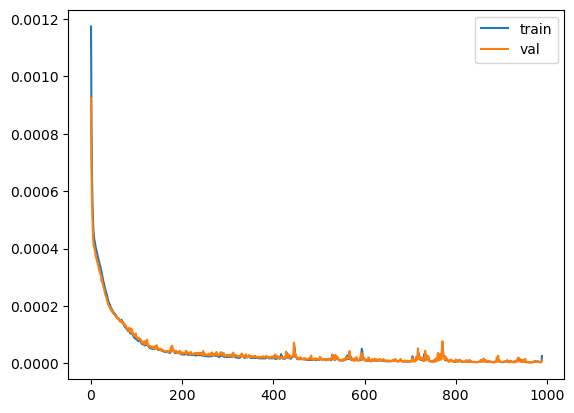

In [117]:
plt.plot(training_loss[10:], label='train')
plt.plot(val_loss[10:], label='val')
plt.legend()
plt.show()


In [5]:
class ExtendedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, scalar_output_dim, ann_hidden_dims):
        super(ExtendedLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc_next_step = nn.Linear(hidden_dim, output_dim)

        self.ann_layers = nn.ModuleList()
        last_dim = hidden_dim  
        for next_dim in ann_hidden_dims:
            self.ann_layers.append(nn.Linear(last_dim, next_dim))
            self.ann_layers.append(nn.ReLU())
            last_dim = next_dim

        self.fc_scalar_final = nn.Linear(last_dim, scalar_output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        lstm_out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        next_step_prediction = self.fc_next_step(lstm_out[:, -1, :])

        ann_out = hn[-1]  
        for layer in self.ann_layers:
            ann_out = layer(ann_out)

        scalar_prediction = self.fc_scalar_final(ann_out)

        return next_step_prediction, scalar_prediction


In [15]:
# pseudo labels that increase slowly as time progress
cognitive_scores = np.linspace(40, 70, X.shape[0]).reshape(-1, 1)
# normalize cog scores
cognitive_scores = (cognitive_scores - cognitive_scores.mean()) / cognitive_scores.std()
cognitive_scores.shape

(97, 1)

In [16]:
# split into train and test
X_train, X_test, y_train, y_test, cog_train, cog_test = train_test_split(X, y, cognitive_scores, test_size=0.2, random_state=42)

In [29]:
# training 
X_tensor = torch.tensor(X_train, dtype=torch.float)
y_tensor = torch.tensor(y_train, dtype=torch.float)
cog_tensor = torch.tensor(cog_train, dtype=torch.float)

X_val = torch.tensor(X_test, dtype=torch.float)
y_val = torch.tensor(y_test, dtype=torch.float)
cog_val = torch.tensor(cog_test, dtype=torch.float)

dataset = TensorDataset(X_tensor, y_tensor, cog_tensor)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

val_dataset = TensorDataset(X_val, y_val, cog_val)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

model = ExtendedLSTM(input_dim=86, hidden_dim=128, layer_dim=1, output_dim=86, scalar_output_dim=1, ann_hidden_dims=[64, 32, 16])
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 1000
lstm_loss = []
cog_loss = []
lstm_val_loss = []
cog_val_loss = []

min_val_loss = 1000
min_val_epoch = 0

for epoch in range(num_epochs):
    model.train()  
    epoch_lstm_loss = 0.0
    epoch_cog_loss = 0.0
    epoch_lstm_val_loss = 0.0
    epoch_cog_val_loss = 0.0

    # training 
    for inputs, labels, cog in dataloader:
        optimizer.zero_grad()
        lstm_out, scalar_out = model(inputs)
        loss = criterion(lstm_out, labels)
        loss2 = criterion(scalar_out, cog)
        combined_loss = loss + loss2
        combined_loss.backward()
        optimizer.step()
        epoch_lstm_loss += loss.item() * inputs.size(0) 
        epoch_cog_loss += loss2.item() * inputs.size(0) 

    epoch_lstm_loss /= len(dataloader.dataset)
    epoch_cog_loss /= len(dataloader.dataset)
    lstm_loss.append(epoch_lstm_loss)
    cog_loss.append(epoch_cog_loss)

    # validation
    model.eval() 
    with torch.no_grad():
        for inputs, labels, cog in val_dataloader:
            lstm_out, scalar_out = model(inputs)
            loss = criterion(lstm_out, labels)
            loss2 = criterion(scalar_out, cog)
            epoch_lstm_val_loss += loss.item() * inputs.size(0) 
            epoch_cog_val_loss += loss2.item() * inputs.size(0) 

    # calculate average validation loss for the epoch
    epoch_lstm_val_loss /= len(val_dataloader.dataset)
    epoch_cog_val_loss /= len(val_dataloader.dataset)
    lstm_val_loss.append(epoch_lstm_val_loss)
    cog_val_loss.append(epoch_cog_val_loss)

    if epoch_lstm_val_loss < min_val_loss:
        min_val_loss = epoch_lstm_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        min_val_epoch = epoch

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], LSTM Training Loss: {epoch_lstm_loss:.8f}, Cog Training Loss: {epoch_cog_loss:.8f}, LSTM Validation Loss: {epoch_lstm_val_loss:.8f}, Cog Validation Loss: {epoch_cog_val_loss:.8f}')



Epoch [10/1000], LSTM Training Loss: 0.00675547, Cog Training Loss: 0.06923751, LSTM Validation Loss: 0.00553772, Cog Validation Loss: 0.06775095
Epoch [20/1000], LSTM Training Loss: 0.00060628, Cog Training Loss: 0.02157001, LSTM Validation Loss: 0.00069245, Cog Validation Loss: 0.03387258
Epoch [30/1000], LSTM Training Loss: 0.00046001, Cog Training Loss: 0.02158486, LSTM Validation Loss: 0.00043313, Cog Validation Loss: 0.02342212
Epoch [40/1000], LSTM Training Loss: 0.00032379, Cog Training Loss: 0.01236343, LSTM Validation Loss: 0.00029247, Cog Validation Loss: 0.01466675
Epoch [50/1000], LSTM Training Loss: 0.00042590, Cog Training Loss: 0.01550530, LSTM Validation Loss: 0.00036335, Cog Validation Loss: 0.01740496
Epoch [60/1000], LSTM Training Loss: 0.00032702, Cog Training Loss: 0.01106552, LSTM Validation Loss: 0.00038443, Cog Validation Loss: 0.01652618
Epoch [70/1000], LSTM Training Loss: 0.00035289, Cog Training Loss: 0.01790812, LSTM Validation Loss: 0.00035608, Cog Valida

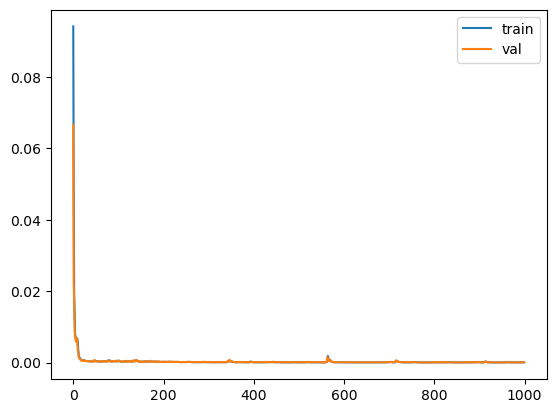

In [30]:
# plot 
import matplotlib.pyplot as plt

plt.plot(lstm_loss, label='train')
plt.plot(lstm_val_loss, label='val')
plt.legend()
plt.show()

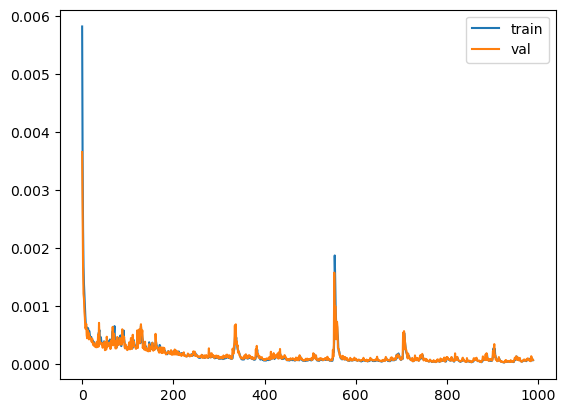

In [32]:
# zoomed in 
plt.plot(lstm_loss[10:], label='train')
plt.plot(lstm_val_loss[10:], label='val')
plt.legend()
plt.show()

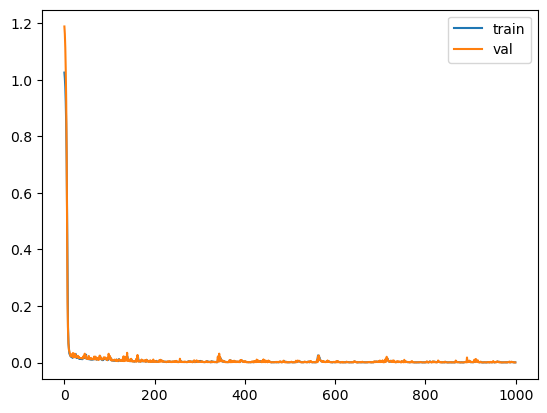

In [31]:
# plot 
plt.plot(cog_loss, label='train')
plt.plot(cog_val_loss, label='val')
plt.legend()
plt.show()

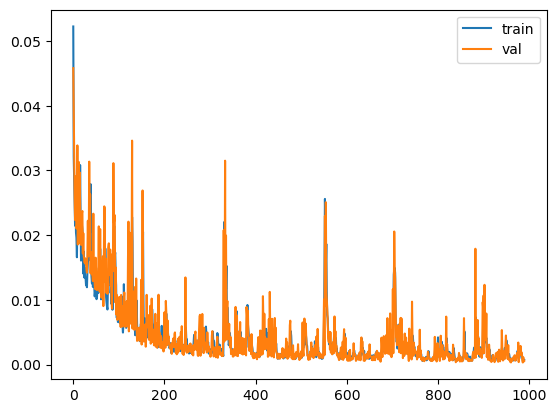

In [33]:
# zoomed in
plt.plot(cog_loss[10:], label='train')
plt.plot(cog_val_loss[10:], label='val')
plt.legend()
plt.show()
